In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc


import warnings
warnings.filterwarnings("ignore")

### Part 1 Load Data

In [2]:
pwd

"/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/Bella's Code"

In [34]:
fraud_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Fraud/Fraud_Data.csv')
ip_address_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Fraud/IpAddress_to_Country.csv')

In [4]:
fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


In [5]:
ip_address_data.head(3)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China


In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
for column in fraud_data.columns:
    uniques = fraud_data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              151112	 [ 22058 333320   1359 150084 221365]
signup_time          151112	 ['2015-02-24 22:55:49' '2015-06-07 20:39:50' '2015-01-01 18:52:44'
 '2015-04-28 21:13:25' '2015-07-21 07:09:52']
purchase_time        150679	 ['2015-04-18 02:47:11' '2015-06-08 01:38:54' '2015-01-01 18:52:45'
 '2015-05-04 13:54:50' '2015-09-09 18:40:53']
purchase_value         122	 [34 16 15 44 39]
device_id            137956	 ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ' 'ATGTXKYKUDUQN'
 'NAUITBZFJKHWW']
source                   3	 ['SEO' 'Ads' 'Direct']
browser                  5	 ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
sex                      2	 ['M' 'F']
age                     58	 [39 53 41 45 18]
ip_address           143512	 [7.32758369e+08 3.50311388e+08 2.62147382e+09 3.84054244e+09
 4.15583117e+08]
class                    2	 [0 1]


##### we notice that there are many overlappings in purchase_time, device_id, and ip_address, one step we need to implement is to check if there are any account with same purchase time, device id and ip_address has the obvious feature of fraud.

In [35]:
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])

In [36]:
fraud_data['purchase_time_weekday'] = fraud_data['purchase_time'].dt.dayofweek+1
fraud_data['signup_time_weekday'] = fraud_data['signup_time'].dt.dayofweek+1
fraud_data['purchase_time_week_num'] = fraud_data['purchase_time'].dt.week
fraud_data['signup_time_week_num'] = fraud_data['signup_time'].dt.week

In [10]:
ip_address_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [11]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class,purchase_time_weekday,signup_time_weekday,purchase_time_week_num,signup_time_week_num
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646,4.011819,4.027265,24.658571,16.501740
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336,2.006203,2.006972,11.651557,9.814287
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000,1.000000,1.000000,1.000000,1.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000,2.000000,2.000000,16.000000,8.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000,4.000000,4.000000,25.000000,16.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000,6.000000,6.000000,34.000000,25.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000,7.000000,7.000000,51.000000,34.000000


In [12]:
ip_address_data.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


##### there seems to be no outliers in these variables and no NA values

##### here we notice that the range of ip_address in the ip_address_data is much narrow than which in fraud data, therefore we should expect there are some records leaving the variable of country as NA

##### then we merge the two dataset together

In [37]:
countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    tmp = ip_address_data[(ip_address_data['lower_bound_ip_address'] <= ip_address) &
                          (ip_address_data['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('not_found')
        
fraud_data['country'] = countries

fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,purchase_time_weekday,signup_time_weekday,purchase_time_week_num,signup_time_week_num,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,6,2,16,9,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,1,7,24,23,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,4,4,1,1,United States


### Part 2 Data visualization

#### 1) Fraud vs Time variables

#### 1.1) Fraud vs time difference

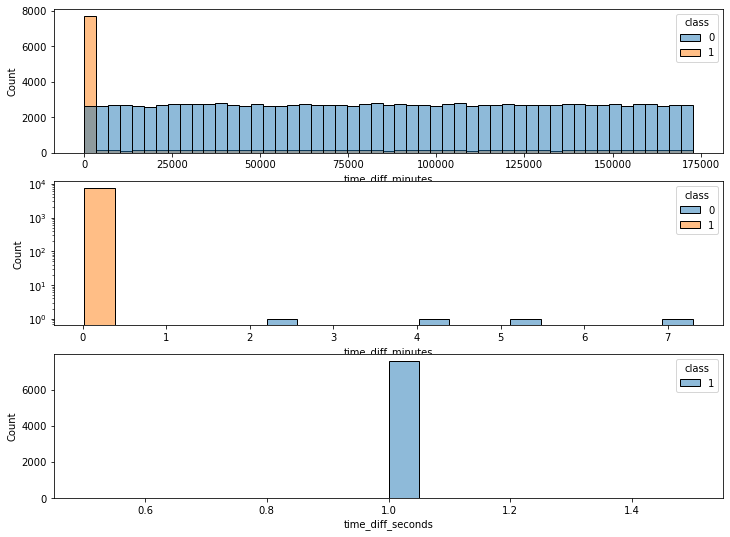

In [56]:
temp = fraud_data[['signup_time', 'purchase_time', 'class']]
temp['time_diff_minutes'] = (temp['purchase_time'] - temp['signup_time']).dt.total_seconds()/60
temp['time_diff_seconds'] = (temp['purchase_time'] - temp['signup_time']).dt.total_seconds()

fig, ax = plt.subplots(3, 1, figsize = (12, 9))

sns.histplot(data = temp, x = 'time_diff_minutes', hue = 'class', ax = ax[0])
sns.histplot(data = temp[temp['time_diff_minutes']<= 10], x = 'time_diff_minutes', hue = 'class', ax = ax[1], bins = 20)
sns.histplot(data = temp[temp['time_diff_seconds']<= 60], x = 'time_diff_seconds', hue = 'class', ax = ax[2], bins = 20)
# ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

In [72]:
fraud_data['time_diff_seconds'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()


##### the plot above shows that most of the account with fraud tend to make the purchase with in one second 

##### 1.2) Fraud vs day_of_week

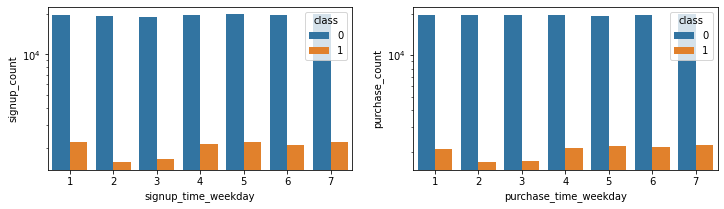

In [59]:
temp = fraud_data[['signup_time_weekday', 'purchase_time_weekday', 'class']]

temp_group_signup_time_weekday = temp.groupby(['signup_time_weekday', 'class']).count().reset_index()
temp_group_signup_time_weekday.columns = ['signup_time_weekday', 'class', 'signup_count']

temp_group_purchase_time_weekday = temp.groupby(['purchase_time_weekday', 'class']).count().reset_index()
temp_group_purchase_time_weekday.columns = ['purchase_time_weekday','class', 'purchase_count']

fig, ax = plt.subplots(1, 2, figsize = (12, 3))

sns.barplot(data = temp_group_signup_time_weekday, 
            x = 'signup_time_weekday', y = 'signup_count', hue = 'class', ax = ax[0])
sns.barplot(data = temp_group_purchase_time_weekday, 
            x = 'purchase_time_weekday', y = 'purchase_count', hue = 'class', ax = ax[1])
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

##### the two plots above show that the signup and purchase of fraud account are realtively low in Tuesday and Wednesday. While for none fraud accounts, the distribution  between different weekdays are not so abvious.

##### 1.3) Fraud vs week_num¶

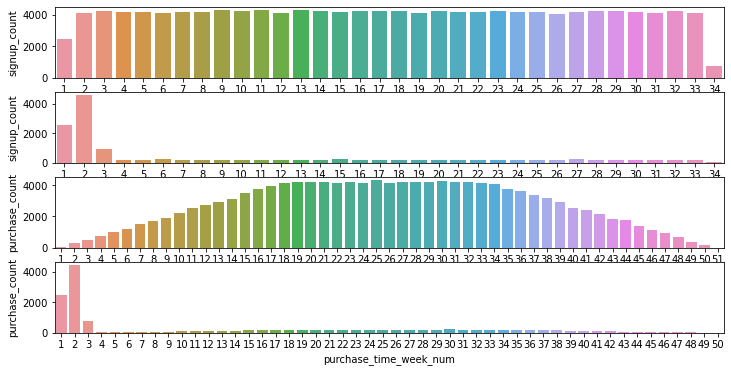

In [17]:
temp = fraud_data[['signup_time_week_num', 'purchase_time_week_num', 'class']]

temp_class1 = temp[temp['class'] == 1][['signup_time_week_num', 'purchase_time_week_num']]
temp_class0 = temp[temp['class'] == 0][['signup_time_week_num', 'purchase_time_week_num']]

temp_class1_group_signup_time_week_num = temp_class1.groupby(['signup_time_week_num']).count().reset_index()
temp_class1_group_signup_time_week_num.columns = ['signup_time_week_num', 'signup_count']

temp_class0_group_signup_time_week_num = temp_class0.groupby(['signup_time_week_num']).count().reset_index()
temp_class0_group_signup_time_week_num.columns = ['signup_time_week_num', 'signup_count']

temp_class1_group_purchase_time_week_num = temp_class1.groupby(['purchase_time_week_num']).count().reset_index()
temp_class1_group_purchase_time_week_num.columns = ['purchase_time_week_num','purchase_count']

temp_class0_group_purchase_time_week_num = temp_class0.groupby(['purchase_time_week_num']).count().reset_index()
temp_class0_group_purchase_time_week_num.columns = ['purchase_time_week_num','purchase_count']


fig, ax = plt.subplots(4,1, figsize = (12, 6))

sns.barplot(data = temp_class0_group_signup_time_week_num, 
            x = 'signup_time_week_num', y = 'signup_count', ax = ax[0])
sns.barplot(data = temp_class1_group_signup_time_week_num, 
            x = 'signup_time_week_num', y = 'signup_count', ax = ax[1])
sns.barplot(data = temp_class0_group_purchase_time_week_num, 
            x = 'purchase_time_week_num', y = 'purchase_count', ax = ax[2])
sns.barplot(data = temp_class1_group_purchase_time_week_num, 
            x = 'purchase_time_week_num', y = 'purchase_count', ax = ax[3])
plt.show()

##### one intereating  phenomenon of the distribution of week numbers between class 0 and 1 is that both of the signup and purchase peak weeks concentrates on the begining of the year

##### 2) Fraud vs perchase value

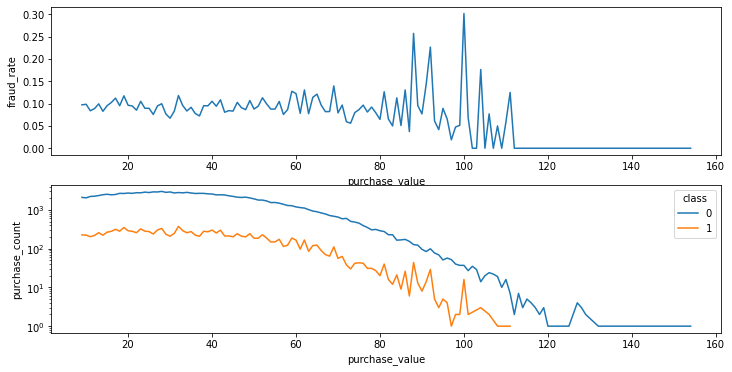

In [18]:
temp_rate = fraud_data.groupby('purchase_value')['class'].mean().reset_index()
temp_rate.columns = ['purchase_value','fraud_rate']
temp_count = fraud_data.groupby(['purchase_value', 'class']).size().reset_index()
temp_count.columns = ['purchase_value', 'class', 'purchase_count']

fig, ax = plt.subplots(2, 1 ,figsize = (12, 6))

sns.lineplot(data = temp_rate, x = 'purchase_value', y = 'fraud_rate', ax = ax[0])
sns.lineplot(data = temp_count, x = 'purchase_value', y = 'purchase_count', hue = 'class', ax = ax[1])
ax[1].set_yscale("log")

plt.show()

##### the two plots above shows that most of the fraud accounts purchase concentrates the group of less than 60, while some of the fraud are near the value of 100, but few of them will exceed 100

##### 3) Fraud vs source

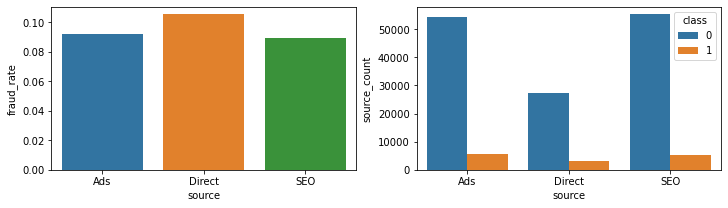

In [19]:
temp_rate = fraud_data.groupby('source')['class'].mean().reset_index()
temp_rate.columns = ['source','fraud_rate']
temp_count = fraud_data.groupby(['source', 'class']).size().reset_index()
temp_count.columns = ['source', 'class', 'source_count']

fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = temp_rate, x = 'source', y = 'fraud_rate', ax = ax[0])
sns.barplot(data = temp_count, x = 'source', y = 'source_count', hue = 'class', ax = ax[1])

plt.show()

##### the two plots above shows that the fraud rate of Direct source is a little bit higher than the other two sources. Hhowere, it's abvious that Ads and SEO are still the main source of purchase.

##### 4) Fraud vs brower

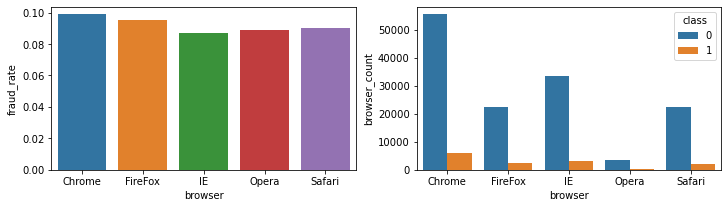

In [20]:
temp_rate = fraud_data.groupby('browser')['class'].mean().reset_index()
temp_rate.columns = ['browser','fraud_rate']
temp_count = fraud_data.groupby(['browser', 'class']).size().reset_index()
temp_count.columns = ['browser', 'class', 'browser_count']

fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = temp_rate, x = 'browser', y = 'fraud_rate', ax = ax[0])
sns.barplot(data = temp_count, x = 'browser', y = 'browser_count', hue = 'class', ax = ax[1])

plt.show()

##### There is no significant difference in fraud rate between the five browsers.

##### 5) Fraud vs sex

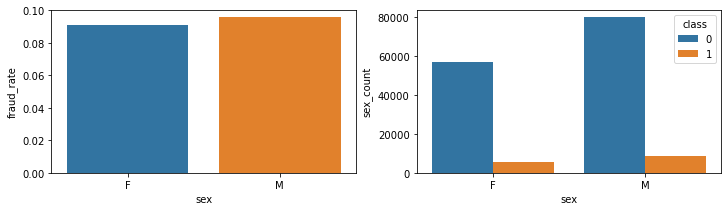

In [21]:
temp_rate = fraud_data.groupby('sex')['class'].mean().reset_index()
temp_rate.columns = ['sex','fraud_rate']
temp_count = fraud_data.groupby(['sex', 'class']).size().reset_index()
temp_count.columns = ['sex', 'class', 'sex_count']

fig, ax = plt.subplots(1, 2 ,figsize = (12, 3))

sns.barplot(data = temp_rate, x = 'sex', y = 'fraud_rate', ax = ax[0])
sns.barplot(data = temp_count, x = 'sex', y = 'sex_count', hue = 'class', ax = ax[1])

plt.show()

##### There is no significant difference in fraud rate between female and male.

##### 6) Fraud vs age

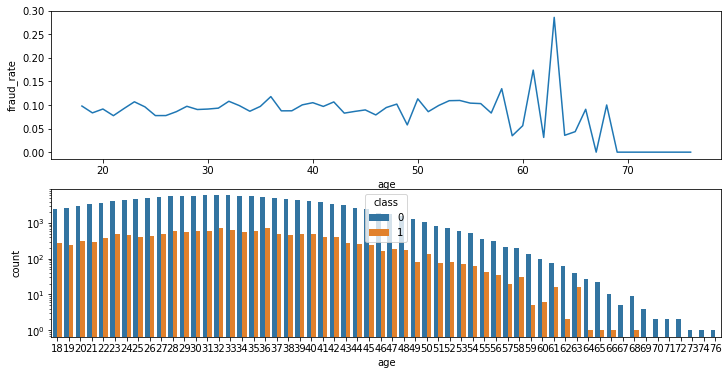

In [22]:
temp_rate = fraud_data.groupby('age')['class'].mean().reset_index()
temp_rate.columns = ['age','fraud_rate']
temp_count = fraud_data.groupby(['age', 'class']).size().reset_index()
temp_count.columns = ['age', 'class', 'count']

fig, ax = plt.subplots(2, 1 ,figsize = (12, 6))

sns.lineplot(data = temp_rate, x = 'age', y = 'fraud_rate', ax = ax[0])
sns.barplot(data = temp_count, x = 'age', y = 'count', hue = 'class', ax = ax[1])
ax[1].set_yscale("log")

plt.show()

##### users in the age group 25 to 40 are more likely to take fraud purchase, some users registered with an age older than 60 also has the high possibility of fraud.

##### 7) Fraud vs country

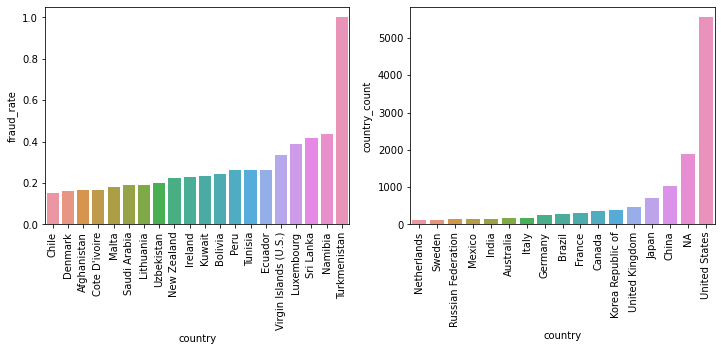

In [23]:
temp_rate = fraud_data.groupby('country')['class'].mean().reset_index()
temp_rate.columns = ['country','fraud_rate']
temp_count = fraud_data[fraud_data['class'] == 1].groupby(['country']).size().reset_index()
temp_count.columns = ['country', 'country_count']

fig, ax = plt.subplots(1, 2 ,figsize = (12, 4))

sns.barplot(data = temp_rate[(temp_rate['fraud_rate'] >= 0.15)], 
            x = 'country', y = 'fraud_rate', ax = ax[0],
            order = temp_rate[(temp_rate['fraud_rate'] >= 0.15)].sort_values('fraud_rate').country)
sns.barplot(data = temp_count[(temp_count['country_count'] >= 100)], 
            x = 'country', y = 'country_count', ax = ax[1],
            order = temp_count[(temp_count['country_count'] >= 100)].sort_values('country_count').country)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)

plt.show()

<AxesSubplot:xlabel='country', ylabel='user_id'>

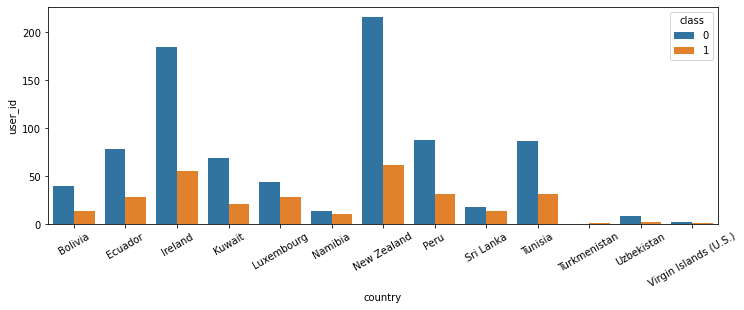

In [24]:
temp_rate = temp_rate[(temp_rate['fraud_rate'] >= 0.2)].sort_values('fraud_rate')
country = temp_rate['country'].values
boolean_series = fraud_data.country.isin(country)
filtered_df = fraud_data[boolean_series]
filtered_df = filtered_df.groupby(['country', 'class'])['user_id'].count().reset_index()
fig, ax = plt.subplots(figsize=(12, 4))
plt.xticks(rotation= 30)

sns.barplot(data = filtered_df, x = 'country', y = 'user_id', hue = 'class')

##### the three plots above shows that countries including Virgin Islands (U.S.), Luxembourg, Sri Lanka, Namibia,and Turkmenistan have an absolute high value of fraud rate.  But the customer base of these countries as also very low.
##### Countries including 'Janpan', 'China', and 'US' have a large number of fraud accounts, but their customer base are also high.

##### 8) shared device or unique device

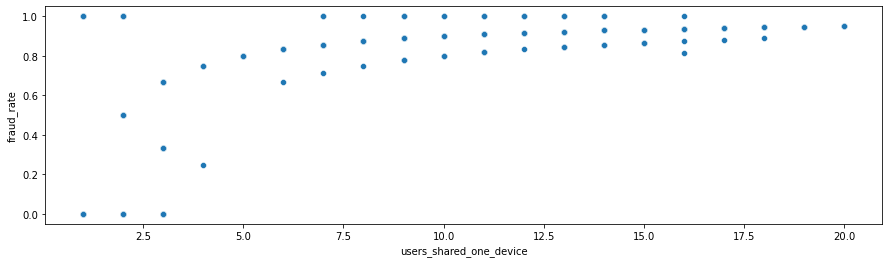

In [61]:
device_count = fraud_data[['device_id', 'user_id']].groupby(['device_id'])['user_id'].count().reset_index()
device_count.columns = ['device_id', 'users_shared_one_device']
device_rate = fraud_data[['device_id', 'class']].groupby(['device_id'])['class'].mean().reset_index()
device_rate.columns = ['device_id', 'fraud_rate']
temp = pd.merge(left = device_count, right = device_rate, 
                how = 'left', left_on = 'device_id', right_on = 'device_id' )
temp.sort_values('fraud_rate')
fig, ax = plt.subplots(figsize = (15, 4))

sns.scatterplot(data = temp, x = 'users_shared_one_device', y = 'fraud_rate')

plt.show()

In [62]:
fraud_data = pd.merge(left = fraud_data, right = device_count, 
                how = 'left', left_on = 'device_id', right_on = 'device_id' )

##### from this plot we notice that the more account share the same device, the more likely they are fraud accounts

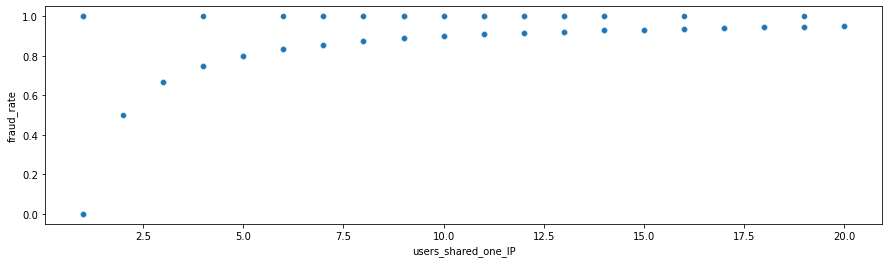

In [65]:
ip_count = fraud_data[['ip_address', 'user_id']].groupby(['ip_address'])['user_id'].count().reset_index()
ip_count.columns = ['ip_address', 'users_shared_one_IP']
ip_rate = fraud_data[['ip_address', 'class']].groupby(['ip_address'])['class'].mean().reset_index()
ip_rate.columns = ['ip_address', 'fraud_rate']
temp = pd.merge(left = ip_count, right = ip_rate, 
                how = 'left', left_on = 'ip_address', right_on = 'ip_address' )
temp.sort_values('fraud_rate')
fig, ax = plt.subplots(figsize = (15, 4))

sns.scatterplot(data = temp, x = 'users_shared_one_IP', y = 'fraud_rate')

plt.show()

In [67]:
fraud_data = pd.merge(left = fraud_data, right = ip_count, 
                how = 'left', left_on = 'ip_address', right_on = 'ip_address' )

##### from this plot we notice that the more account share the same ip_address, the more likely they are fraud accounts

### 3. Model Fitting

##### based on the visualization part, we have already figure out some important features which have high correlations with the fraud activities like:
##### 1. time difference between signup and purchase
##### 2. purchase_time_week_num
##### 3. signup_time_week_num
##### 4. purchase value
##### 5. share the same device or not
##### 6. share the same ip address or not
##### 7. age
##### 8. country

##### Consider there are too many category variables, it's better to adopt tree_based models.
##### Here we use the random forest to fit the model

In [73]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'purchase_time_weekday', 'signup_time_weekday',
       'purchase_time_week_num', 'signup_time_week_num', 'country',
       'users_shared_one_device', 'users_shared_one_IP', 'time_diff_seconds'],
      dtype='object')

In [89]:
features = ['purchase_value','age', 
            'time_diff_seconds', 'purchase_time_weekday', 
            'signup_time_weekday','purchase_time_week_num', 'signup_time_week_num', 
            'country', 'users_shared_one_device', 'users_shared_one_IP']

X_train = pd.get_dummies(fraud_data[features], 
                         columns = ['purchase_time_weekday', 
            'signup_time_weekday','purchase_time_week_num', 'signup_time_week_num', 
            'country'], drop_first = True)

y_train = fraud_data['class']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [91]:
rf_reg = RandomForestClassifier(max_features=5)
rf_reg.fit(X_train, y_train)

RandomForestClassifier(max_features=5)

In [92]:
model = rf_reg
train_con_matrix = confusion_matrix(y_train, model.predict(X_train))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test)), 4))

train matrix: 
 [[109609      0]
 [     6  11274]]
train accuracy: 1.0

 test matrix: 
 [[27343     9]
 [ 1326  1545]]
test accuracy: 0.9558


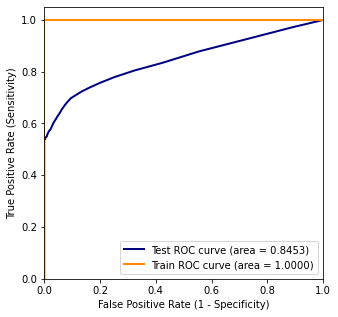

In [93]:
y_test_pred_prob = model.predict_proba(X_test)[:,1]
y_train_pred_prob = model.predict_proba(X_train)[:,1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=[5, 5])

plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='Test ROC curve (area = %0.4f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.4f)' % roc_auc_train)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()